# Usefull Time series related blogs 2

## Forecasting with Trees: Hybrid Modeling for Time Series

Tree-based algorithms are well-known in the machine learning ecosystem. By far, they are famous to dominate the approach of every tabular supervised task. Given a tabular set of features and a target to predict, they can achieve satisfactory results without so much effort or particular preprocessing. The splitting criterion, at the basis of their learning procedure, it’s effective to focus only on the relevant features and on the range of useful values.

The weak spot of tree-based models is that they technically can’t extrapolate on higher/lower feature values than seen in training data. It is almost impossible for them to predict values outside the seen interval. On the contrary, classical linear regression may suffer less the dynamic behaviors of data. **Since linear regression excels at extrapolating trends while gradient boosting excels at learning interactions, why not combine them?** We aim to create “hybrid” forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

It’s easier to think about ‘hybrid models’ when working with deep learning. The infinite architecture combinations and the personalized training process of neural networks provide great benefits in terms of customizations (as an example, Exponential Smoothing stacked with LSTM). Developing customized hybrid solutions with tree models is trickier. A good resource in this sense is represented by linear-tree: a python package that provides hybrid models architectures that mix the learning ability of tree-based and linear models. Not only, but also LGBM or XGBoost have introduced the ability to fit gradient boosting with linear approximations in the tree leaves.

### Experiment Setup

To design effective hybrids, we need a general understanding of how time series are constructed. Many time series can be closely described by adding together just three components (trend, season, and cycles) plus an essentially unpredictable term (error).

$$ series = trend + seasons + cycles + error $$

Learning the time series components could be figured out as an iterative procedure:
- firstly, learn the trend and subtract it out from the original series to get the series of residuals;
- secondly, learn the seasonality from the detrended residuals and subtract the seasons out;
- in the end, learn the cycles and subtract the cycles out.

In other words, we use one algorithm to fit the specific component series and then a second one to fit the residual series. The final forecast is the addition of the predictions of the various model components.

To experiment with the building of hybrids, we start generating some simulated series with a double seasonality pattern and a trend component.

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

In [2]:
### UTLITY FUNCTIONS FOR SYNTETIC DATA GENERATION ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    
    return y


def gen_randomwalk(timesteps, noise):

    y = np.random.normal(0,noise, (timesteps,))
    
    return y.cumsum()

The unknown trend is obtained fitting a cubic polynomial on a random walk series. The result is a smoothed trend line which is added to the seasonal component to obtain the final time series to forecast. We generate multiple time series, in this way, and try to forecast them benchmarking various solutions.

In [3]:
### SYNTETIC DATA GENERATION ###

df = {}
n_series = 100
timesteps = 2_000
for i in range(n_series):
    
    np.random.seed(i)
    seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
    seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)
    
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2,3])
    m = LinearRegression()
    trend = m.fit(X, rw).predict(X)

    df[f'ts_{i}'] = seas1 + seas2 + trend
    
df = pd.DataFrame(df) + 3_000
df.shape

(2000, 100)

Text(0.5, 1.0, 'Seasonalities + Trend')

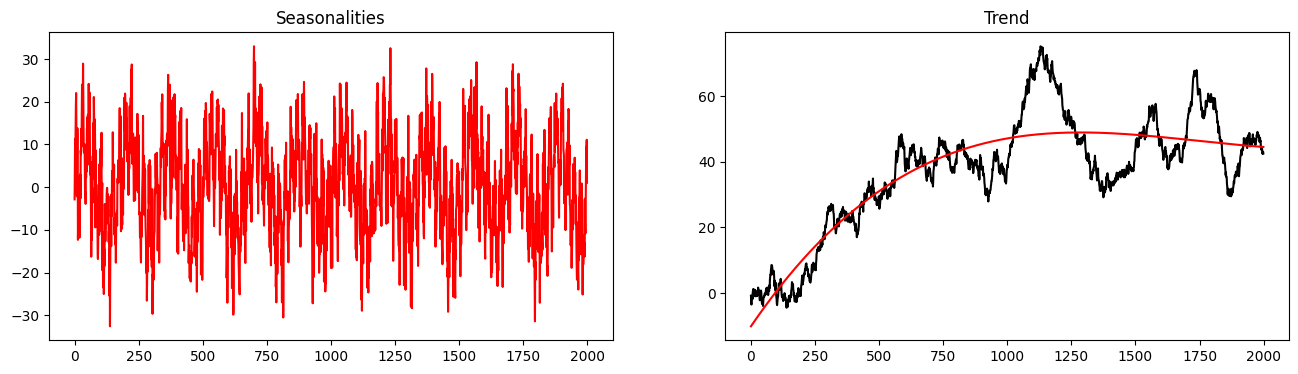

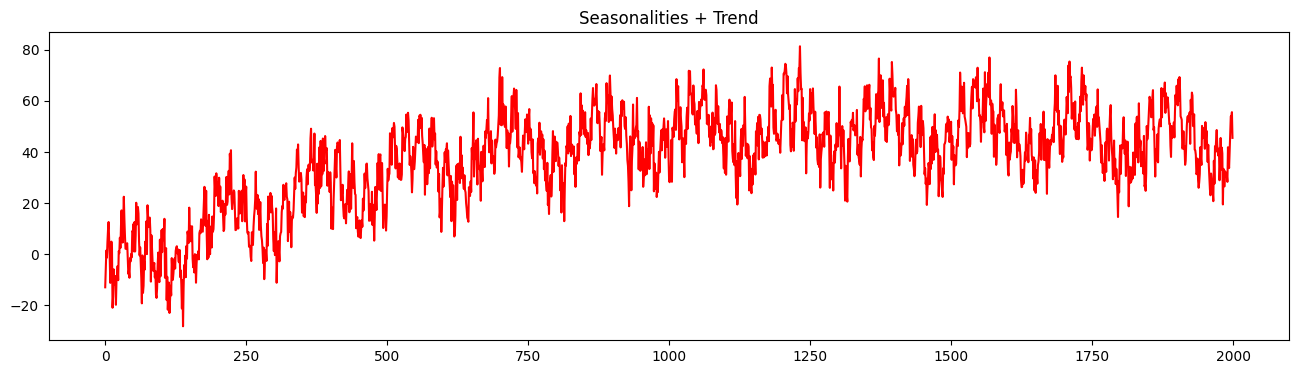

In [4]:
### EXAMPLE OF SYNTETIC DATA GENERATION ###

np.random.seed(1234)
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)

rw = gen_randomwalk(timesteps=timesteps, noise=1)
X = np.linspace(0,10, timesteps).reshape(-1,1)
X = np.power(X, [1,2,3])
m = LinearRegression()
trend = m.fit(X, rw).predict(X)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(seas1 + seas2, c='red'); plt.title('Seasonalities')
plt.subplot(122)
plt.plot(rw, c='black'); plt.plot(trend, c='red'); plt.title('Trend')

plt.figure(figsize=(16,4))
plt.plot(seas1 + seas2 + trend, c='red'); plt.title('Seasonalities + Trend')

<AxesSubplot: >

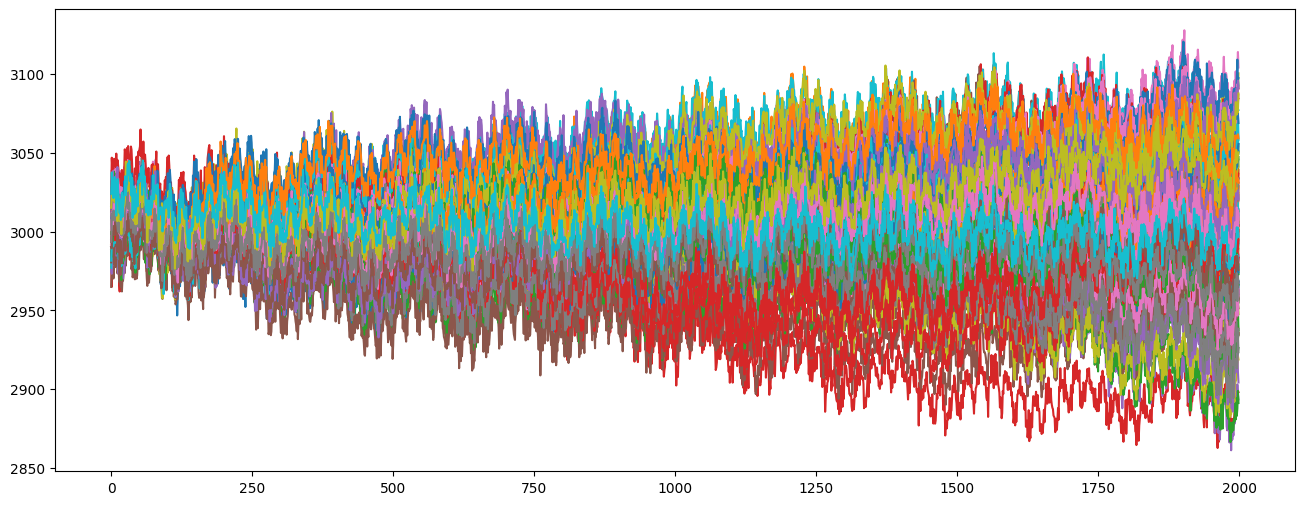

In [5]:
### PLOT GENERATED DATA ###

df.plot(legend=False, figsize=(16,6))

We try four different approaches:

- fit a naive linear model, after choosing the best polynomial basis;
- transform the target with a differencing transformation to make it stationary;
- **hybrid additive.** Firstly a linear model, with an optimal polynomial basis, is fitted to extrapolate the trend. Secondly, the detrended series is modeled with a gradient boosting;
- **hybrid inclusive.** Fit a gradient boosting including also the extrapolated trend (obtained fitting a linear model with an optimal polynomial basis) as a feature.

Except for the naive solution, all the approaches use as features some spline transformations. They are good to capture the seasonality patterns simply by looking at the series. The optimal trend is chosen by searching for the best polynomial basis on the training data. A gradient boosting is fitted, while searching for some optimal parameters configurations, using a temporal cross-validation strategy.

In [6]:
### FIT MODELS AND STORE RESULTS ###

mse_naive = []
mse_diff = []
mse_hybrid_add = []
mse_hybrid_incl = []

df_naive = (df*np.nan).copy()
df_diff = (df*np.nan).copy()
df_hybrid_add = (df*np.nan).copy()
df_hybrid_incl = (df*np.nan).copy()

ts = tqdm(df.columns)
for c in ts:
    
    y_test = df[c].tail(24*7*4)
    y_train = df[c][~df[c].index.isin(y_test.index)]
    X_train = np.arange(0, y_train.shape[0]).reshape(-1,1)
    X_test = np.arange(X_train[-1], X_train[-1]+y_test.shape[0]).reshape(-1,1)
    
    train_mask = df[c].index.isin(y_train.index)
    test_mask = df[c].index.isin(y_test.index)
    
    period = 24
    n_splines = 3
    n_knots = n_splines +1
    st24 = SplineTransformer(
        degree = 3,
        n_knots = n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias = True,
    )
    period = 168
    n_splines = 6
    n_knots = n_splines +1
    st168 = SplineTransformer(
        degree = 3,
        n_knots = n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias = True,
    )
    
    CV = TimeSeriesSplit(n_splits=4)
    base_model = LGBMRegressor(random_state=33, n_jobs=-1) 
    param_grid = {'n_estimators': [30,50,70,90,110,130]}
    
    trend2 = (-cross_val_score(
        LinearRegression(), np.power(X_train,[1,2]), y_train, 
        cv=CV, scoring='neg_mean_squared_error'
    )).mean()
    trend3 = (-cross_val_score(
        LinearRegression(), np.power(X_train,[1,2,3]), y_train, 
        cv=CV, scoring='neg_mean_squared_error'
    )).mean()
    
    powers = [1,2] if trend2 <= trend3 else [1,2,3]

    trend = LinearRegression() 
    trend.fit(np.power(X_train,powers), y_train)
    train_trend = trend.predict(np.power(X_train,powers))
    test_trend = trend.predict(np.power(X_test,powers))
    
    df_naive.loc[train_mask, c] = train_trend
    df_naive.loc[test_mask, c] = test_trend
    mse_naive.append(mse(y_test, trend.predict(np.power(X_test,powers))))
    score_naive = f"Naive Trend: {round(np.mean(mse_naive),3)}"
    
    X_train = np.hstack([st24.fit_transform(X_train), st168.fit_transform(X_train)])
    X_test = np.hstack([st24.transform(X_test), st168.transform(X_test)])
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train[1:], np.diff(y_train))
    
    df_diff.loc[train_mask, c] = np.cumsum(np.append(y_train.head(1), model.predict(X_train[1:])))
    df_diff.loc[test_mask, c] = np.cumsum(np.append(y_train.tail(1), model.predict(X_test)))[1:]
    mse_diff.append(mse(y_test, np.cumsum(np.append(y_train.tail(1), model.predict(X_test)))[1:]))
    score_diff = f"Differencing: {round(np.mean(mse_diff),3)}"
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train-train_trend)
    
    df_hybrid_add.loc[train_mask, c] = model.predict(X_train)+train_trend
    df_hybrid_add.loc[test_mask, c] = model.predict(X_test)+test_trend    
    mse_hybrid_add.append(mse(y_test, model.predict(X_test)+test_trend))
    score_hybrid_add = f"Hybrid Additive: {round(np.mean(mse_hybrid_add),3)}"
    
    X_train = np.hstack([train_trend.reshape(-1,1), X_train])
    X_test = np.hstack([test_trend.reshape(-1,1), X_test]) 
    
    model = GridSearchCV(base_model, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    
    df_hybrid_incl.loc[train_mask, c] = model.predict(X_train)
    df_hybrid_incl.loc[test_mask, c] = model.predict(X_test)     
    mse_hybrid_incl.append(mse(y_test, model.predict(X_test)))
    score_hybrid_incl = f"Hybrid Inclusive: {round(np.mean(mse_hybrid_incl),3)}"
    
    desc = f"{score_naive} | {score_diff} | {score_hybrid_add} | {score_hybrid_incl} |"
    ts.set_description(desc)

Naive Trend: 1353.755 | Differencing: 473.041 | Hybrid Additive: 1251.465 | Hybrid Inclusive: 427.517 |: 100%|██████████| 100/100 [53:35<00:00, 32.16s/it] 


The hybrid inclusive approach obtains the lowest mean test error, followed by the differencing method. The hybrid additive underperforms our expectations since it registers an error nearly three times higher than the differencing approach. Generally speaking, differencing the target is always a great benchmark when modeling dynamic systems (like the one presented in our experiment). The great surprise is represented by the huge difference in performances between the hybrid methods. Let’s visually inspect some results to see what may happen.

In [ ]:
### TEST ERROR DISTRIBUTIONS ###

scores = pd.DataFrame({
    f'{score_naive}': mse_naive,
    f'{score_diff}': mse_diff,
    f'{score_hybrid_add}': mse_hybrid_add,
    f'{score_hybrid_incl}': mse_hybrid_incl
})

scores.plot.box(figsize=(11,6), title='MSEs on Test', ylabel='MSE')

In [ ]:
### PLOT PREDICTIONS ###

c = 'ts_11' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

In [ ]:
### PLOT PREDICTIONS ###

c = 'ts_33' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

In [ ]:
### PLOT PREDICTIONS ###

c = 'ts_73' 

df[c].plot(figsize=(16,6), label='true', alpha=0.3, c='black')

df_diff[c].plot(figsize=(16,6), label='differencing pred', c='magenta')
df_hybrid_add[c].plot(figsize=(16,6), label='hybrid addictive pred', c='red')
df_hybrid_incl[c].plot(figsize=(16,6), label='hybrid inclusive pred', c='blue')
df_naive[c].plot(figsize=(16,6), label='trend pred', c='lime', linewidth=3)

plt.xlim(0, timesteps)
plt.axvspan(0, timesteps-test_mask.sum(), alpha=0.2, color='orange', label='TRAIN')
plt.axvspan(timesteps-test_mask.sum(), timesteps, alpha=0.2, color='green', label='TEST')
plt.legend()

From the above bunch of images, we can better understand the ‘failure’ of the additive approach. Its performances are strictly related to the goodness of the previous trend fit. If the trend estimates are inaccurate also the final forecastings are garbage. This behavior is mitigated by the inclusive hybrid approach since the trend is included as a feature in the model. Therefore the gradient boosting can correct/mitigate the final forecast errors.

## Time Series Forecasting with Feature Selection

When approaching for the first time a forecasting task, it’s a good practice to start adopting standard and baseline solutions. In the first part of the project, we must dedicate our time to understanding the business needs and conducting adequate explorative analyses. If we can’t wait to build a predictive model, the best option is to fit naive models. This also sounds good since it may help in understanding the data, adopting an adequate validation strategy, or introducing fancy ideas.

After this preliminary phase, **when we are more confident about the achieved results, we can focus more on the engineering choices to develop the most adequate solution**. There are a lot of activities we could optimize. From the data processing to the model inference, we have to take care lot of aspects to make our solution works the best.

Sometimes providing forecasts in a fast and effective way may be a need. In that case, we have to configure our pipeline to provide predictions in the fastest way while maintaining an adequate performance level. Retraining the models from scratch is important but not mandatory. Since it may not grant performance boost/stability, we risk wasting precious time on retraining every time we have to forecast. **The possibility to reuse models and make forecasts without a mandatory fit it’s the first advantage to speed up forecasting.**

At the same time, **we could increase the speed of forecasting with some simple yet effective tricks**. For example, everyone knows feature selection as a technique to reduce the feature dimensionality received as input by a predictive model. Feature selection is an important step in most machine learning pipelines applied with the primary scope to improve performance. **When discharging features we are reducing the complexity of a model resulting also in lower inference times.**



### Experiment Setup

We simulate multiple time series with an hourly frequency and a double seasonality (daily and weekly). We also add a trend, obtained from a smoothed random walk, to introduce a stochastic behavior.

The last parts of the series are used as a test set where we measure forecasting errors and the inference time required to make predictions. For our experiment, we simulate a hundred independent time series. We say “independent” since all the series are not related to each other despite they show very similar behaviors. In this way, we individually model them.

In [1]:
import numpy as np 
import pandas as pd 
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

from tsprial.forecasting import ForecastingCascade, ForecastingChain

In [2]:
### UTILITY FUNCTIONS TO SIMULATE TIME SERIES AND STORE FORECASTING METRICS ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y

def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

def gen_ts(timesteps, amp, freq, noise, random_state=0):
    np.random.seed(random_state)
    
    if isinstance(freq, (int,float)):
        seas = gen_sinusoidal(timesteps=timesteps, amp=amp, freq=freq, noise=noise)
    elif np.iterable(freq) and not isinstance(freq, str):
        seas = np.zeros(timesteps)
        for f in freq:
            if isinstance(f, (int,float)):
                seas += \
                    gen_sinusoidal(timesteps=timesteps, amp=amp, freq=f, noise=noise)
            else:
                raise ValueError("freq not understood.")
    else:
        raise ValueError("freq not understood.")
    
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2])
    trend = LinearRegression().fit(X, rw).predict(X)
    
    return seas + trend


def get_metrics(model, X, y, metrics=None):
    
    score = {
        'mse': [model.score(X, y, scoring='mse')],
        'mae': [model.score(X, y, scoring='mae')],
        'mape': [model.score(X, y, scoring='mape')],
        'rmse': [model.score(X, y, scoring='rmse')],
    }
    
    if metrics is not None:
        for metric,s in score.items():
            metrics[metric].extend(s)
    else:
        metrics = score
    
    return metrics

In [3]:
### SIMULATE SYNTHETIC TIME SERIES ### 

n_series, timesteps = 100, 4_000

df = {}
for i in range(n_series):
    df[f'ts_{i}'] = gen_ts(
        timesteps, 
        amp=10, freq=[24,24*7], noise=4,
        random_state=i
    )
df = pd.DataFrame(
    df, index=pd.date_range(
    '2020-01-01', periods=timesteps, freq='H'
    )
)

df.shape

(4000, 100)

<AxesSubplot: >

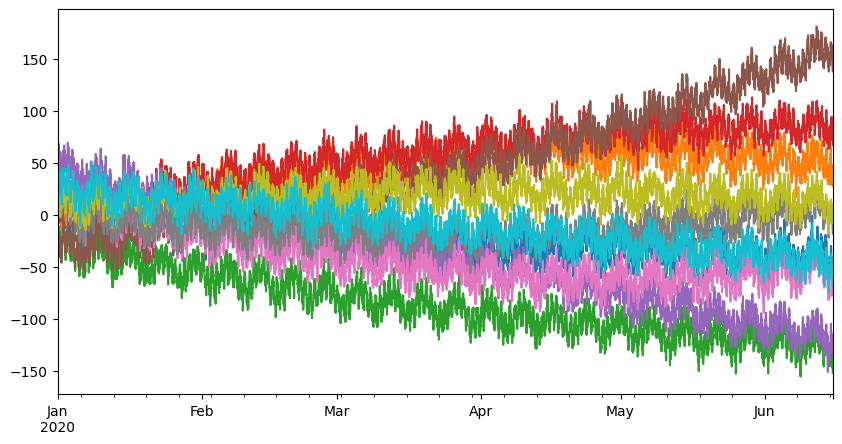

In [4]:
### PLOT SYNTHETIC TIME SERIES ###

df.sample(n=10, axis=1, random_state=33).plot(
    legend=False, figsize=(10,5))

In [5]:
### TRAIN TEST SPLIT ###

y_train, y_test = train_test_split(df, test_size=24*7, shuffle=False)

### INTIALIZE EMPTY DICT TO STORE RESULTS ###

results = {}

y_train.shape, y_test.shape

((3832, 100), (168, 100))

Both recursive and direct forecasting strategies are tested. These methodologies forecast time series using as input lagged values of the target. In other words, to forecast the next hour's value we use the previous available hourly observations rearranged in a more friendly tabular format. Carrying out feature selection for time series forecasting is as simple as in standard tabular supervised tasks. The selection algorithm simply operates on the lagged target features. Below is an example of feature selection using recursive forecasting.

### Recursive Forecasting

In [6]:
### SELECT MEANINGFUL LAGS ###

supports = []

model = ForecastingCascade(
    make_pipeline(
        SelectFromModel(
            Ridge(), 
            threshold='median',
            max_features=72,
        ), 
        Ridge()
    ),
    lags=range(1,24*7+1),
    use_exog=False,
)

for c in tqdm(df.columns):
    
    model.fit(None, y_train[c])
    supports.append(
        model.estimator_['selectfrommodel'].get_support(indices=True)
    )
    
supports = np.asarray(supports)

100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


In [7]:
### FORECASTING WITH ALL LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):
    
    model = ForecastingCascade(
        Ridge(),
        lags=range(1,24*7+1),
        use_exog=False
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['recursive full'] = metrics

print(metrics)

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

{'mse': 48.05696853461647, 'mae': 5.481909306888324, 'mape': 0.9726704858696964, 'rmse': 6.764007568488088, 'tot time': 14.312273740768433, 'std time': 0.06875510278480698}


In [9]:
### FORECASTING WITH DUMMY LAGS SELECTION ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):
    
    model = ForecastingCascade(
        Ridge(),
        lags=range(24,24*8,24),
        use_exog=False
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['recursive dummy'] = metrics

print(metrics)

100%|██████████| 100/100 [00:05<00:00, 18.99it/s]

{'mse': 67.29899960764843, 'mae': 6.490345961979978, 'mape': 1.299169682126994, 'rmse': 7.962270165339615, 'tot time': 0.3973653316497803, 'std time': 0.005029083364801007}


In [10]:
### FORECASTING WITH SELECTED LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):

    model = ForecastingCascade(
        Ridge(),
        lags=supports[i] +1,
        use_exog=False
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['recursive filtered'] = metrics

print(metrics)

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]

{'mse': 48.97977022728355, 'mae': 5.530049636923783, 'mape': 1.013987057733762, 'rmse': 6.811106627446635, 'tot time': 10.648535251617432, 'std time': 0.032655319506386}


### Direct Forecasting

In the case of direct forecasting, where we have to fit a separate estimator for each forecasting step, the procedure remains quite the same. We make the selection for each forecasting step. Different subsets of important lags are selected by each estimator. To aggregate the results and produce only a unique set of meaningful lags, we choose the ones that are more frequently selected.

In [11]:
### SELECT MEANINGFUL LAGS ###

supports = []

model = ForecastingChain(
    make_pipeline(
        SelectFromModel(
            Ridge(), threshold='median',
        ), 
        Ridge()
    ),
    n_estimators=24*7,
    lags=range(1,24*7+1),
    use_exog=False,
    n_jobs=-1
)

for c in tqdm(df.columns):
    
    model.fit(None, y_train[c])
    supports.append(
        np.argsort(np.asarray([
            est.estimator_['selectfrommodel'].get_support() 
            for est in model.estimators_
        ]).sum(0))[-72:]
    )
    
supports = np.asarray(supports)

100%|██████████| 100/100 [05:38<00:00,  3.39s/it]


In [12]:
### FORECASTING WITH ALL LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):

    model = ForecastingChain(
        Ridge(),
        n_estimators=24*7,
        lags=range(1,24*7+1),
        use_exog=False,
        n_jobs=-1
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['direct full'] = metrics

print(metrics)

100%|██████████| 100/100 [06:26<00:00,  3.87s/it]

{'mse': 39.46555415883777, 'mae': 5.0104592132423384, 'mape': 0.7879780084830553, 'rmse': 6.247999158074163, 'tot time': 51.38723874092102, 'std time': 0.32200748791113076}


In [13]:
### FORECASTING WITH DUMMY LAGS SELECTION ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):

    model = ForecastingChain(
        Ridge(),
        n_estimators=7,
        lags=range(24,24*8,24),
        use_exog=False,
        n_jobs=-1
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['direct dummy'] = metrics

print(metrics)

100%|██████████| 100/100 [00:04<00:00, 21.79it/s]

{'mse': 63.91225292359602, 'mae': 6.340832101317055, 'mape': 1.2505373067530132, 'rmse': 7.7900026565666725, 'tot time': 0.3193223476409912, 'std time': 0.002620658923119059}


In [14]:
### FORECASTING WITH SELECTED LAGS ###

times = []
metrics = None
fh = np.arange(24*7)

for i,c in tqdm(enumerate(df.columns), total=n_series):
    
    model = ForecastingChain(
        Ridge(),
        n_estimators=round(24*7 / (supports[i].min() +1)), 
        lags=supports[i] +1, 
        use_exog=False,
        n_jobs=-1
    )
    model.fit(None, y_train[c])
    init = time()
    pred = model.predict(fh)
    total_time = time() - init
    times.append(total_time)
    
    metrics = get_metrics(model, fh, y_test[c], metrics)


metrics = {m:np.mean(s) for m,s in metrics.items()}
metrics['tot time'] = np.sum(times)
metrics['std time'] = np.std(times)
results['direct filtered'] = metrics

print(metrics)

100%|██████████| 100/100 [03:21<00:00,  2.02s/it]

{'mse': 41.687250738547135, 'mae': 5.153754897129753, 'mape': 0.8724183044543373, 'rmse': 6.414979337303102, 'tot time': 21.61870837211609, 'std time': 0.19730787312125075}


### Results

Lags selection is strictly connected with the model performances. In a pure autoregressive context, without additional exogenous variables, lagged target values are the only valuable information to provide good forecasts. Expecting a significant improvement of the error metrics, using feature selection, may be too optimistic. Let's inspect the results.

In [15]:
### SHOW RESULTS IN TABULAR FORMAT ###

results = pd.DataFrame(results).T
results

mse       mae      mape      rmse   tot time  \
recursive full      48.056969  5.481909  0.972670  6.764008  14.312274   
recursive dummy     67.299000  6.490346  1.299170  7.962270   0.397365   
recursive filtered  48.979770  5.530050  1.013987  6.811107  10.648535   
direct full         39.465554  5.010459  0.787978  6.247999  51.387239   
direct dummy        63.912253  6.340832  1.250537  7.790003   0.319322   
direct filtered     41.687251  5.153755  0.872418  6.414979  21.618708   

                    std time  
recursive full      0.068755  
recursive dummy     0.005029  
recursive filtered  0.032655  
direct full         0.322007  
direct dummy        0.002621  
direct filtered     0.197308

## Extreme Churn Prediction: Forecasting without features


Nowadays we live in a data-centric world. With every action, we generate a significant amount of data that can be collected and used to produce valuable business insights. Big tech companies know these dynamics very well. By monitoring our daily activities, it’s possible to identify our habits and preferences to customize offers and increase the probability of engagements.

With the scope of maximizing the value of the business, we can adopt machine learning to detect when customers are close to churning, identify the best retention strategies, recommend the best services or products according to their preferences, and so on. The possibilities concerning the application of artificial intelligence solutions for customer engagement are many. Having at our disposal a full and rich set of data may be a great added value for our needs. As data scientists, we can build powerful and complex pipelines by merging different data sources and building meaningful features to feed our predictive algorithms.

This sounds like magic and a dream for every data scientist. Since collecting and storing data should be a must for every data-centric company, it may not be so easy and free. **Working with few observations, low-quality data, or without meaningful predictors may happen often.** In these cases, we should reinvent ourselves to deliver the best solution with what we have at our disposal.

In this post, we develop a solution to detect when customers are about to leave. **We don’t apply standard or complex machine learning approaches. We simulate operating in an extreme scenario** where we have only stored the purchase information for each user together with the relative amounts. We don’t know anything about our customers and can’t merge any valuable external data source to help us to enrich our dataset. **With simple and effective statistical techniques, we aim to achieve reasonable results which can be adopted also to benchmark more complex solutions.**

### Simulation Setup

We imagine being a company that sells products or services. We don’t offer subscriptions. Our customers make purchases on their own when they need. For each customer’s order, we can retrieve the date and the corresponding money amount. These are the only things we can collect and obtain.

For the scope of this post, we simulate some orders for a fixed number of customers in a given time range. We register a churn when a customer stops ordering from us and no longer buys anything.

In [16]:
import datetime
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [17]:
### SIMULATE DATA ###

def generate_data(idx):

    while True:
        try:
            breaks = np.sort(np.random.choice(len(dates), 2)) 
            length = int(np.random.randint(6, np.diff(breaks) // 15))
        except ValueError:
            continue
        break

    col_amnt = np.random.normal(300, 100, size=length)
    col_date = np.sort(np.random.choice(dates[breaks[0]:breaks[1]],
                                        length, replace=False))
    
    customer_hist = pd.DataFrame({
        'InvoiceDate': col_date, 'Amount': col_amnt,
    })
    customer_hist['CustomerID'] = idx
    
    return customer_hist


end = pd.Timestamp("2022-12-31").replace(hour=0, minute=0, second=0, microsecond=0)
start = pd.Timestamp("2021-1-1")
dates = pd.date_range(start, end, freq='D', normalize=True)

cstm = [f'id{i}' for i in range(1000)]  
df = pd.concat(map(generate_data, cstm), axis=0, ignore_index=True)
df['InvoiceDateDiff'] = df.groupby('CustomerID')['InvoiceDate'].diff().dt.days
df = df.dropna()

print(df.shape)
df.head()

(11732, 4)


InvoiceDate      Amount CustomerID  InvoiceDateDiff
1  2021-10-01  423.384309        id0            122.0
2  2021-11-04   64.718931        id0             34.0
3  2021-12-25  144.760042        id0             51.0
4  2022-01-14  431.037434        id0             20.0
5  2022-02-02  278.287000        id0             19.0

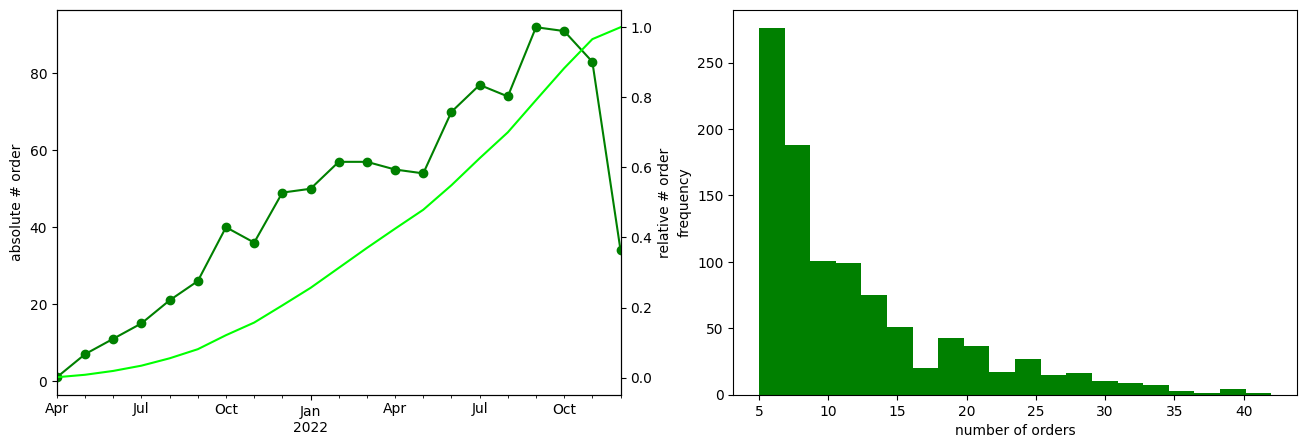

In [18]:
### PLOT ORDER FREQUENCY ###

monthlychurns = df.groupby('CustomerID')['InvoiceDate'].max() \
    .apply(lambda x: x.replace(day=1)).value_counts().sort_index()

true = monthlychurns.cumsum().to_dict()
eval_dates = pd.date_range(start=monthlychurns.index[0], end=end, freq='MS')

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
monthlychurns.plot(
    color='green', marker='o', ax=plt.gca()
)
plt.ylabel('absolute # order')
plt.twinx()
(monthlychurns.cumsum() / monthlychurns.sum()).plot(
    color='lime', ax=plt.gca()
)
plt.ylabel('relative # order')
plt.subplot(1,2,2)
df.groupby('CustomerID')['InvoiceDate'].count().plot(
    kind='hist', color='green', bins=20, ax=plt.gca()
)
plt.xlabel('number of orders'); plt.ylabel('frequency')
plt.show()

From the information at our disposal, we can retrieve how many days passed between two consecutive purchases (i.e. order frequency). **Calculating the difference in days from two adjacent orders is fundamental for developing our solution. We aim to identify churns mainly by looking at the distributions of order frequency of each customer.** If the number of days since the last purchase is far from the usual customer’s order frequency, we are confident to encounter a leaving. In other words, we verify the day's difference, between today and the date of the last order, being greater than in past for each customer.

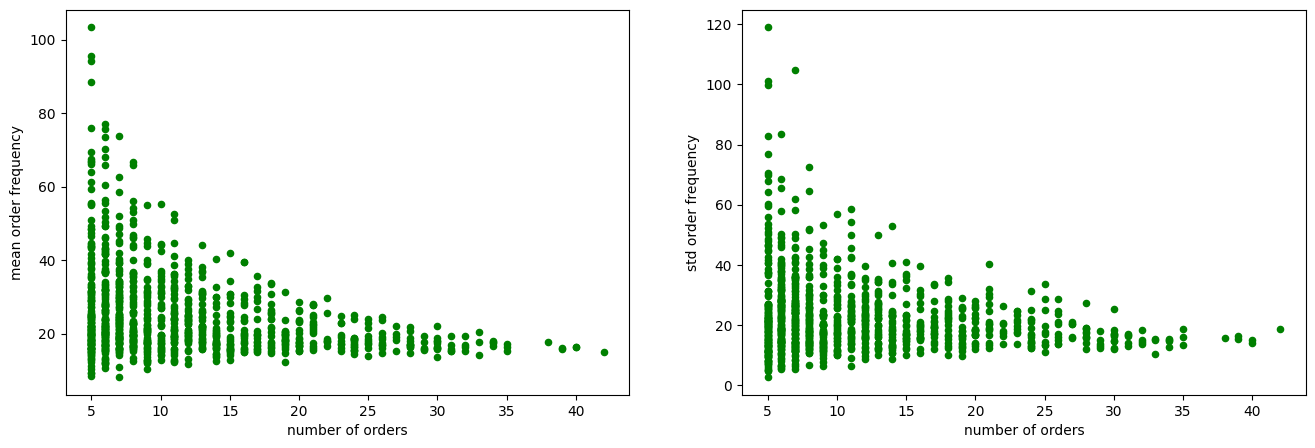

In [19]:
### PLOT NUMBER OF ORDERS vs MEAN/STD OF ORDER FREQUENCY ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
df.groupby('CustomerID')['InvoiceDateDiff'].agg(['mean','count']).plot.scatter(
    x='count', y='mean', color='green', ax=plt.gca()
)
plt.xlabel('number of orders'); plt.ylabel('mean order frequency')
plt.subplot(1,2,2)
df.groupby('CustomerID')['InvoiceDateDiff'].agg(['std','count']).plot.scatter(
    x='count', y='std', color='green', ax=plt.gca()
)
plt.xlabel('number of orders'); plt.ylabel('std order frequency')
plt.show()

Practically speaking, we must develop an algorithm that, studying the order frequency distribution, can alert the risk of churning for every customer on any date. We propose two simple yet effective approaches:

- sigma modeling
- cumulative distribution function (CDF) modeling

With the sigma modeling, we calculate the mean and the standard deviation of order frequency for each customer on a historical period of reference. During inference, we verify if the difference between today's and the last order date is greater than the mean plus n-times sigma. If that happens our customer is no longer buying with the same frequency as before, which may indicate a possible churn.

With the CDF approach, we model the order frequency as a random variable (precisely a truncated normal) building the corresponding inverse monotonic CDF on a historical period of reference for each customer. At inference time, we can identify the probability of any difference, between today’s and the last order date, being greater than a predefined level of confidence. As before, if that happens our customer is no longer buying with the same frequency as before by us. To improve the effectiveness of CDF modeling, we can include also the order amount in the formulation if we consider it meaningful for churn detection. This is important if we want to give more importance to purchases with an amount close to the average customer’s historical expense.

In [20]:
### UTILITY FUNCTIONS TO PREDICT CHURN ###

def get_wtd_mean(vals, scores):

    num_order = np.floor(np.log10(scores.size)).astype(int)
    N = num_order - 1 if num_order else num_order

    inv_rng = 1 / (float('1e' + str(N)) + scores)
    inv_sum = np.sum(inv_rng)
    weights = inv_rng / inv_sum
        
    return np.average(vals, weights=weights)


def generate_norm(grp):
    
    low = grp['InvoiceDateDiff'].min()
    upp = grp['InvoiceDateDiff'].max()
    
    if 'Amount' in grp:
        scores = np.abs(grp['Amount'].values)
        mean = get_wtd_mean(grp['InvoiceDateDiff'], scores)
    else:
        mean = grp['InvoiceDateDiff'].mean()
    std = grp['InvoiceDateDiff'].std()

    trunc_norm = stats.truncnorm(
        (low - mean) / std,
        (upp - mean) / std,
        loc=mean, scale=std
    )

    return trunc_norm


def predict_by_cdf(
        grp, check_date,
        thr = 0.5, min_purch = 5,
    ):
    
    if len(grp) < min_purch:
        return np.nan
    else:
        nrd = generate_norm(grp)
        val = (check_date - grp['InvoiceDate'].max()).days
        return 1 if nrd.cdf(val) > thr else 0


def predict_by_sigma(
        grp, check_date,
        k = 3, min_purch = 5
    ):
    
    if len(grp) < min_purch:
        return np.nan
    else:  
        mnv = grp['InvoiceDateDiff'].mean()
        sdv = grp['InvoiceDateDiff'].std()
        val = (check_date - grp['InvoiceDate'].max()).days
        return 1 if val > mnv + (sdv * k) else 0  

In [21]:
### PREDICT CHURN OVER TIME ###

acc = {
    'pred_sigma': {},
    'pred_cdf_90': {},
    'pred_cdf_50': {},
}

prec = {
    'pred_sigma': {},
    'pred_cdf_90': {},
    'pred_cdf_50': {},
}

rec = {
    'pred_sigma': {},
    'pred_cdf_90': {},
    'pred_cdf_50': {},
}

for train_end in tqdm(eval_dates):
    
    df_train = df[(df['InvoiceDate'] < train_end)].copy()
    df_test = df[(df['InvoiceDate'] >= train_end)].copy()

    train_users = df_train['CustomerID'].unique()
    test_users = df_test['CustomerID'].unique()

    y = pd.Series(np.ones_like(train_users), index=train_users, dtype=int)
    y[y.index.isin(test_users)] = 0
    
    data_grouper = df_train.groupby('CustomerID', sort=False)
    
    df_pred = pd.DataFrame({
        'pred_sigma': data_grouper.apply(predict_by_sigma, 
                                         check_date=train_end),
        'pred_cdf_90': data_grouper.apply(predict_by_cdf, thr=0.9, 
                                           check_date=train_end),
        'pred_cdf_50': data_grouper.apply(predict_by_cdf, thr=0.5, 
                                           check_date=train_end),
        'true': y
    }).dropna()
    
    if not df_pred.empty and (df_pred['true'] > 0).any():
        
        cm = confusion_matrix(df_pred['true'], df_pred['pred_sigma'])
        acc['pred_sigma'][train_end] = cm[1,1] / true[train_end]
        prec['pred_sigma'][train_end] = cm[1,1] / (cm[0,1]+cm[1,1]) \
            if (cm[0,1]+cm[1,1]) > 0 else np.nan
        rec['pred_sigma'][train_end] = cm[1,1] / (cm[1,0]+cm[1,1]) \
            if (cm[1,0]+cm[1,1]) > 0 else np.nan
        cm = confusion_matrix(df_pred['true'], df_pred['pred_cdf_90'])
        acc['pred_cdf_90'][train_end] = cm[1,1] / true[train_end]
        prec['pred_cdf_90'][train_end] = cm[1,1] / (cm[0,1]+cm[1,1]) \
            if (cm[0,1]+cm[1,1]) > 0 else np.nan
        rec['pred_cdf_90'][train_end] = cm[1,1] / (cm[1,0]+cm[1,1]) \
            if (cm[1,0]+cm[1,1]) > 0 else np.nan
        cm = confusion_matrix(df_pred['true'], df_pred['pred_cdf_50'])
        acc['pred_cdf_50'][train_end] = cm[1,1] / true[train_end]
        prec['pred_cdf_50'][train_end] = cm[1,1] / (cm[0,1]+cm[1,1]) \
            if (cm[0,1]+cm[1,1]) > 0 else np.nan
        rec['pred_cdf_50'][train_end] = cm[1,1] / (cm[1,0]+cm[1,1]) \
            if (cm[1,0]+cm[1,1]) > 0 else np.nan

100%|██████████| 21/21 [01:41<00:00,  4.84s/it]


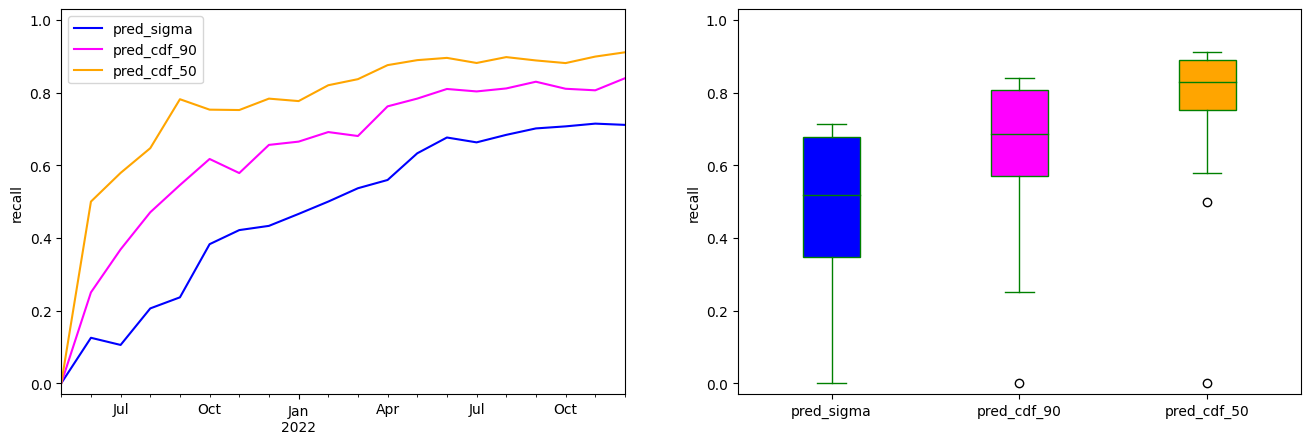

In [22]:
### RECALL PLOTS ###

plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
pd.DataFrame(rec).plot(ax=plt.gca(), color=['blue','magenta','orange'])
plt.ylim([-0.03,1.03]); plt.ylabel('recall')
ax = plt.subplot(1,2,2)
_,props = pd.DataFrame(rec).plot.box(patch_artist=True, color='green', return_type='both', ax=ax)
for patch,color in zip(props['boxes'],['blue','magenta','orange']):
    patch.set_facecolor(color)
plt.ylim([-0.03,1.03]); plt.ylabel('recall')
plt.show()

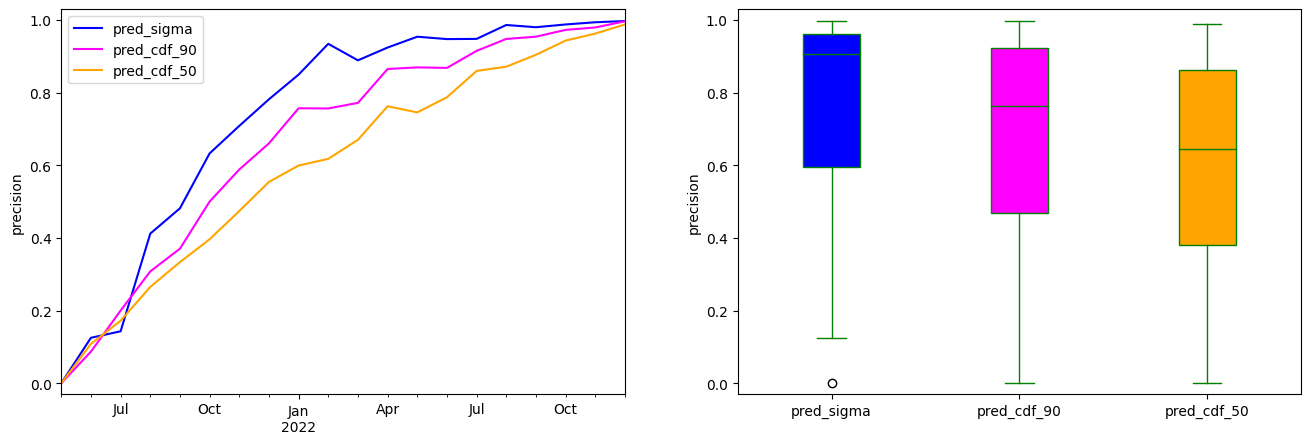

In [23]:
### PRECISION PLOTS ###

plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
pd.DataFrame(prec).plot(ax=plt.gca(), color=['blue','magenta','orange'])
plt.ylim([-0.03,1.03]); plt.ylabel('precision')
ax = plt.subplot(1,2,2)
_,props = pd.DataFrame(prec).plot.box(patch_artist=True, color='green', return_type='both', ax=ax)
for patch,color in zip(props['boxes'],['blue','magenta','orange']):
    patch.set_facecolor(color)
plt.ylim([-0.03,1.03]); plt.ylabel('precision')
plt.show()

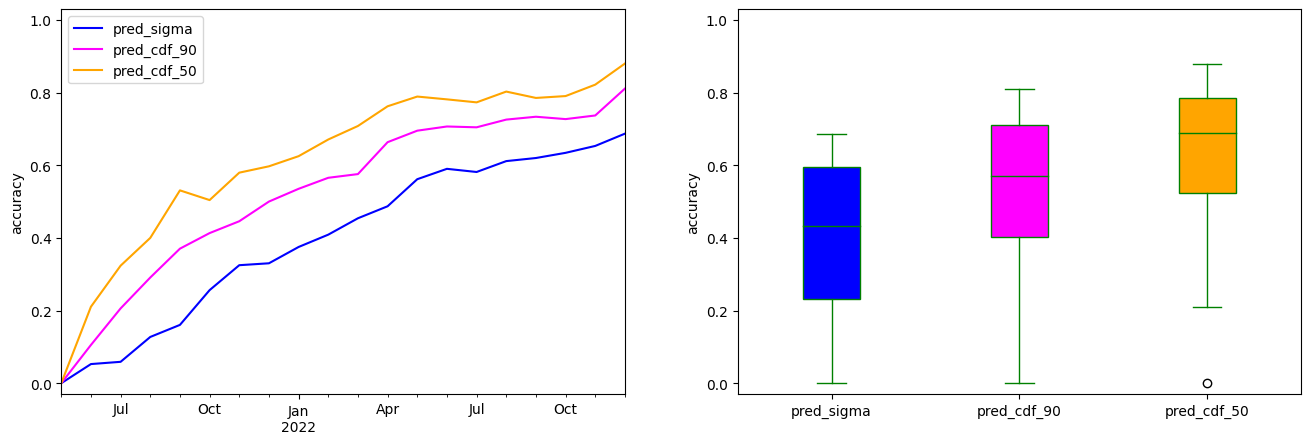

In [24]:
### ACCURACY PLOTS ###

plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
pd.DataFrame(acc).plot(ax=plt.gca(), color=['blue','magenta','orange'])
plt.ylim([-0.03,1.03]); plt.ylabel('accuracy')
ax = plt.subplot(1,2,2)
_,props = pd.DataFrame(acc).plot.box(patch_artist=True, color='green', return_type='both', ax=ax)
for patch,color in zip(props['boxes'],['blue','magenta','orange']):
    patch.set_facecolor(color)
plt.ylim([-0.03,1.03]); plt.ylabel('accuracy')
plt.show()

## PCA for Multivariate Time Series: Forecasting Dynamic High-Dimensional Data

Multi-step ahead forecasting of multivariate time series is known to be a complex predictive task. We have to take care of the large dimensionality of both inputs and outputs; we have to handle the cross-sectional and temporal dependencies adequately; last but not least, we have to ensure an acceptable level of long-term accuracy.

Nowadays, analytic applications which handle huge data in temporal and cardinality dimensions are very common. Accordingly, all the solutions built on top of these systems must be able to manipulate large datasets. In the Internet of Things (IoT) era, it’s usual to deal with large sets of time series, which show, in most cases, strong correlation patterns. These dynamics happen very often in fields like telecommunication, industrial manufacturing, finance, electric grid, and so on.

Supposing being a data scientist. We are responsible for developing a predictive analytic application that provides multi-step forecasts of an IoT system made by correlated and noisy sensors. Multivariate forecasting is widely discussed in the literature. From statistical techniques like VAR (Vector Auto-Regressive Model) to more sophisticated and recent deep learning-based methodologies, there are a lot of available solutions to carry out a predictive task. However, the real world is more sophisticated and cruel than expected. Managing large sets of high-frequency sensors in real-time requires developing solutions that blend an adequate degree of accuracy with reasonable responsive latency.

In this post, we try to develop a predictive application for multivariate and multi-step sensor forecasting that can be used in a near real-time mode. That’s possible by mixing dimensional reduction with forecasting techniques suited for multivariate contexts. The proposed methodology is popular in the economic forecasting literature and is known as Dynamic Factor Modeling [1]. In other words, we stack on top of the results of dimensional reduction techniques (like PCA) our favorite forecasting algorithm to predict future system dynamics.

### Experiment Setup

For the scope of the post, we generate multiple synthetic time series. The series can be separated into two groups according to their sinusoidal dynamics. Everything would be perfect except that the signals are hidden by noise.

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

from tsprial.model_selection import TemporalSplit
from tsprial.forecasting import ForecastingChain

In [26]:
### UTILITY FUNCTION TO GENERATE SINUSOIDAL DATA ###

def gen_sinusoidal(timesteps, amp, freq, noise, kind='sin', random_state=0):
    np.random.seed(random_state)
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    if kind == 'sin':
        y = amp*np.sin(X*(2*np.pi/freq))+e
    elif kind == 'cos':
        y = amp*np.cos(X*(2*np.pi/freq))+e
    else:
        assert False
    return y

In [27]:
### GENERATE SINUSOIDAL SERIES ###

n_series, timesteps = 30, 800

df = {}
for i in range(n_series):
    df[f'ts_{i}'] = gen_sinusoidal(
        timesteps, amp=10, freq=24, noise=20, 
        kind = ('sin' if i%3 > 0 else 'cos'),
        random_state=i
    )
df = pd.DataFrame(
    df, index=pd.date_range(
        '2020-01-01', periods=timesteps, freq='H'
    )
)

df.shape

(800, 30)

We add a good degree of noise to our time series to replicate the chaotic behavior of real-world systems and make the forecasting task more difficult.

<AxesSubplot: >

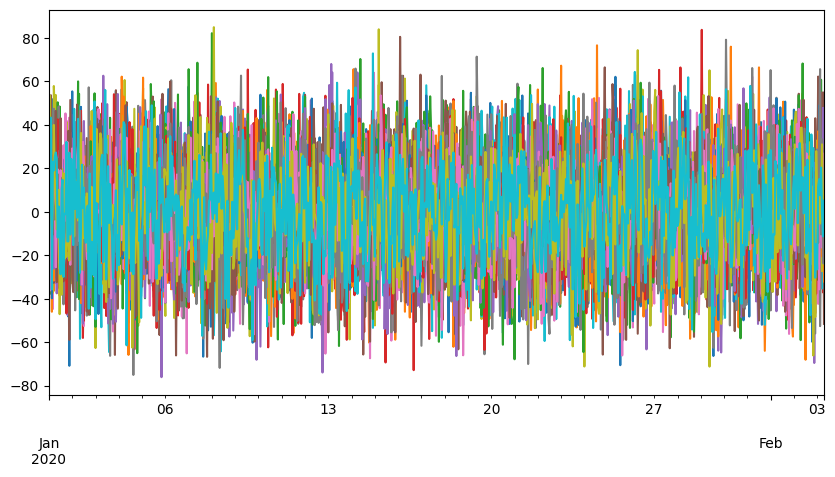

In [28]:
### PLOT SINUSOIDAL DATA ###

df.plot(legend=False, figsize=(10,5))

### Multivariate Dynamic Forecasting

Dynamic Factor Modeling (DFM) is a technique for multivariate forecasting taken from the economic literature [1]. The basic idea behind DFM is that a small number of series can account for the time behavior of a much larger number of variables. If we can obtain accurate estimates of these factors, the entire forecasting task can be simplified by using the estimated dynamic factors instead of using all series.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*2gPVX3WG-5Jd4XBR1jqwTw.png)


The quality of the predictions obtained with DFM depends on two main aspects: the goodness of factors estimation and the accuracy of factors forecasting. There are various ways to estimate dynamic factors. The most common and adopted in the machine learning ecosystem [2] consists in obtaining the principal components of a set of data through orthogonal rotations (PCA).

DFM is also a model-agnostic technique. In other words, any dimensionality reduction and any forecasting strategy can be used to perform forecasting. For our experiment, we use standard PCA and naive direct forecasting. Below is a code snapshot on how to carry out DFM estimation and prediction.

As a final step, we try to solve the same task by simply adopting multivariate direct forecasting on all the series at our disposal. Regardless of the results achieved, this methodology is not sustainable since it requires lagged feature computations for all the series at our disposal. This may require handling an enormous set of lagged variables which makes forecasting not possible for most systems due to physical (memory) and time limits.

We adopt a temporal cross-validation strategy to validate the results of both methodologies and store performances.

In [29]:
### DYNAMIC FACTOR MODELING (DFM) FORECASTING ###

cv = TemporalSplit(n_splits=10, test_size=24, gap=5)
scaler_pca = make_pipeline(StandardScaler(), PCA(n_components=2))
forecaster = ForecastingChain(
    Ridge(),
    n_estimators=cv.test_size,
    lags=range(1,13),
    use_exog=False,
    n_jobs=-1,
)
dfm_error = pd.DataFrame({'DFM': dict(zip(df.columns, np.zeros_like(df.columns, dtype=float)))})

for id_train,id_test in cv.split(df):

    df_train_pca = scaler_pca.fit_transform(df.iloc[id_train])

    forecaster.fit(None, df_train_pca)
    y_pred_dfm = forecaster.predict(np.arange(len(id_test)))

    y_pred_dfm = scaler_pca.steps[0][-1].inverse_transform(
        scaler_pca.steps[-1][-1].inverse_transform(y_pred_dfm)
    )
    y_pred_dfm = pd.DataFrame(y_pred_dfm, columns=df.columns, index=df.iloc[id_test].index)

    dfm_error += pd.DataFrame({
        'DFM': dict(zip(df.columns, 
                 mse(df.iloc[id_test], y_pred_dfm, squared=False, multioutput='raw_values')
                )
            )
    })
    
dfm_error = dfm_error / cv.n_splits
dfm_error.mean()

DFM    19.832434
dtype: float64

In [30]:
### MULTIVARIATE DIRECT FORECASTING ###

cv = TemporalSplit(n_splits=10, test_size=24, gap=5)
forecaster = ForecastingChain(
    make_pipeline(StandardScaler(), Ridge()),
    n_estimators=cv.test_size,
    lags=range(1,13),
    use_exog=False,
    n_jobs=-1,
)
direct_error = pd.DataFrame({'Direct': dict(zip(df.columns, np.zeros_like(df.columns, dtype=float)))})

for id_train,id_test in cv.split(df):

    forecaster.fit(None, df.iloc[id_train])
    y_pred_direct = forecaster.predict(np.arange(len(id_test)))

    y_pred_direct = pd.DataFrame(y_pred_direct, columns=df.columns, index=df.iloc[id_test].index)

    direct_error += pd.DataFrame({
        'Direct': dict(zip(df.columns, 
                 mse(df.iloc[id_test], y_pred_direct, squared=False, multioutput='raw_values')
                )
            )
    })

direct_error = direct_error / cv.n_splits
direct_error.mean()

Direct    27.79028
dtype: float64

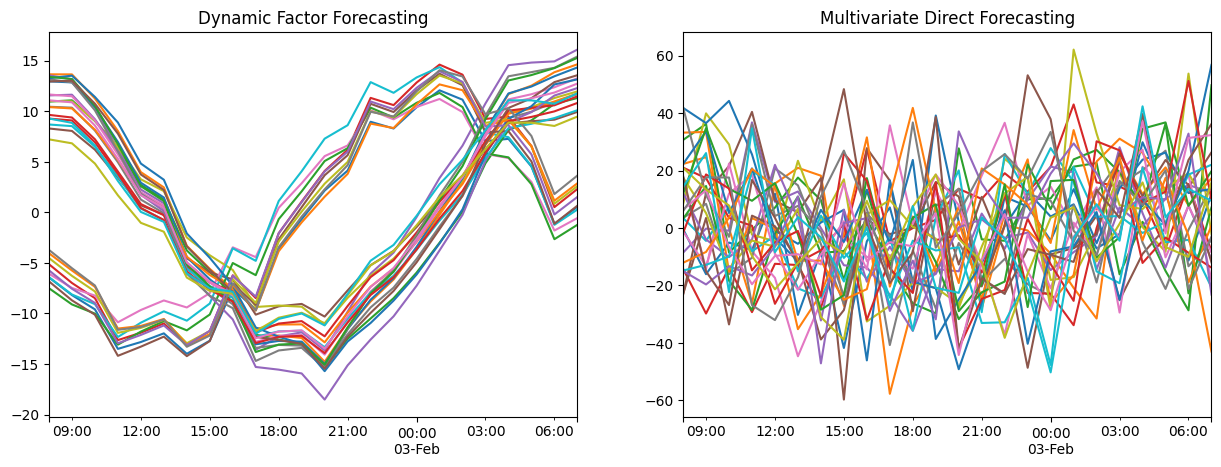

In [31]:
### VISUAL COMPARISON OF FORECASTING METHODS ###

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
y_pred_dfm.plot(legend=False, title='Dynamic Factor Forecasting', ax=plt.gca())
plt.subplot(1,2,2)
y_pred_direct.plot(legend=False, title='Multivariate Direct Forecasting', ax=plt.gca())
plt.show()

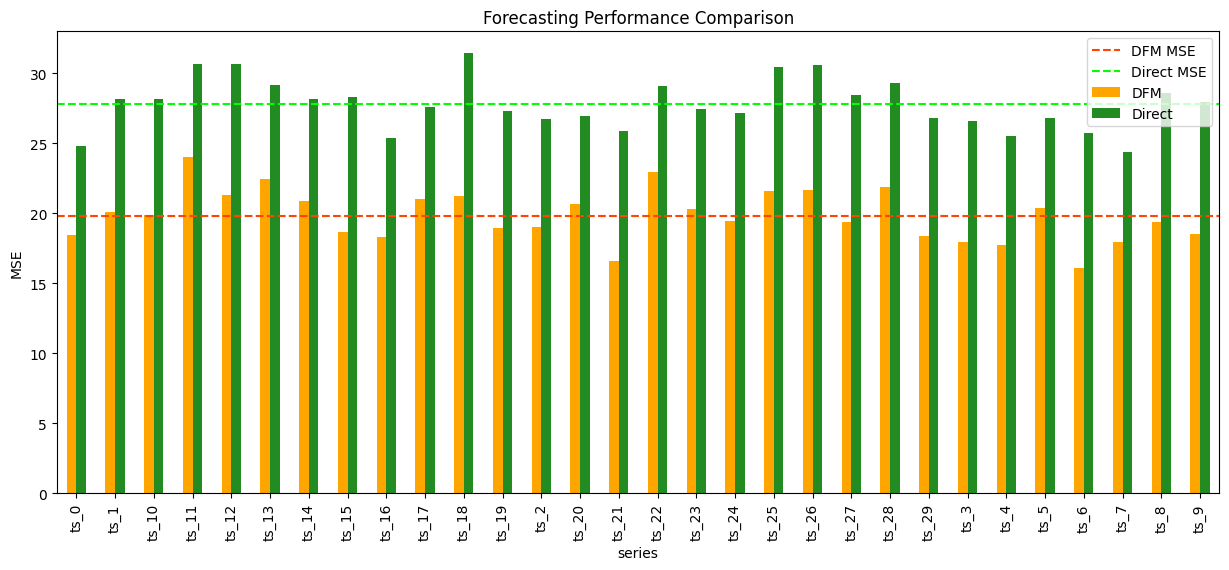

In [32]:
### PERFORMANCE COMPARISON OF FORECASTING METHODS ###

dfm_error.join(direct_error).plot.bar(stacked=False, figsize=(15,6), color=['orange','forestgreen'])
plt.ylabel('MSE'); plt.xlabel('series')
plt.axhline(dfm_error.mean().squeeze(), label='DFM MSE', linestyle='--', c='orangered')
plt.axhline(direct_error.mean().squeeze(), label='Direct MSE', linestyle='--', c='lime')

plt.title('Forecasting Performance Comparison')
plt.legend()
plt.show()

## Forecast Error Measures: Scaled, Relative and other Errors

Both Scaled Error and Relative Error are extrinsic error measures. They depend on another reference forecast to evaluate itself, and more often than not, in practice, the reference forecast is a Naive Forecast or a Seasonal Naive Forecast. In addition to these errors, we will also look at measures like Percent better, cumulative Forecast Error, Tracking Signal, etc.

![](https://miro.medium.com/v2/resize:fit:720/0*udtWmDuPWiIkovvP)

### Relative Error

When we say Relative Error, there are two main ways of calculating it and Shcherbakov calls them Relative Errors and Relative Measures.
Relative Error is when we use the forecast from a reference model as a base to compare the errors and Relative Measures is when we use some forecast measure from reference base model to calculate the errrors.

Relative Error is calculated as below:

$$ {|e_{t}|}\over {a_{t}-f_{t}^{*}} $$

Where $e_{t}$ is the error at timestep t, $a_{t}$ is the ground truth at timestep t, and $f_{t}^{*}$ is the reference forecast at timestep t. 

Similarly Relative Measures are calculated as below:
$$ {MAE}\over{MAE^{*}} $$

Where MAE is the mean absolute error on the forecast and $MAE^{*}$ is MAE of the reference forecast. This measure can be anything really, and not just MAE. 

One disadvantage we can see right away is that it will be undefined when the reference forecast is equal to ground truth. And this can be the case for either very stable time series or intermittent ones where we can have the same ground truth repeated, which makes the naïve forecast equal to the ground truth.

### Scaled Error

It was proposed by Hyndman and Koehler in 2006. They proposed to scale the errors based on the in-sample MAE from the naive forecasting method. So instead of using the ground truth from the previous timestep as the scaling factor, we use the average absolute error across the entire series as the scaling factor.

$$ Scaled_Error = {|e_{t}|}\over{\sum_{i=2}^{n} |a_{i}-a_{i-l}|/(n-1)} $$

Where e is the error at timestep t, n is the length of the timeseries, a is the ground truth at timestep t and l is the offset. l is 1 for a naive forecasting, another alternative that is popularly used is l=seasonal period. Here in-sample MAE is chosen because it is always available and more reliable to estimate the scale as opposed to the out of sample ones.

In [34]:
import numpy as np
import pandas as pd
import plotly.express as px
import cufflinks as cf
from tqdm.autonotebook import tqdm
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/tmp/ipykernel_5042/670569521.py:5: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [35]:
def abs_percent_error(a, f):
    return (np.abs(a-f)/np.abs(a))

def squared_error(a,f):
    return np.power(a-f,2)

def abs_error(a,f):
    return np.abs(a-f)

def symmetric_error(a,f):
    return 2*np.abs(a-f)/(a+f)

metrics = [
"absolute_error",
"squared_error",
"absolute_percent_error",
"symmetric_error"]

In [36]:
a=20
df_metric_l = []
for e in np.arange(-10,11,1):
    f = a-e
    df_metric_l.append({
            "actuals":a,
            "forecast":f,
            "error": a-f,
            "absolute_percent_error": abs_percent_error(a,f),
            "squared_error": squared_error(a,f),
            "absolute_error": abs_error(a,f),
            "symmetric_error": symmetric_error(a,f)
        })

In [37]:
metric_df_a = pd.DataFrame(df_metric_l)
metric_df_a

actuals  forecast  error  absolute_percent_error  squared_error  \
0        20        30    -10                    0.50            100   
1        20        29     -9                    0.45             81   
2        20        28     -8                    0.40             64   
3        20        27     -7                    0.35             49   
4        20        26     -6                    0.30             36   
5        20        25     -5                    0.25             25   
6        20        24     -4                    0.20             16   
7        20        23     -3                    0.15              9   
8        20        22     -2                    0.10              4   
9        20        21     -1                    0.05              1   
10       20        20      0                    0.00              0   
11       20        19      1                    0.05              1   
12       20        18      2                    0.10              4   
13       20        17      3                    0.15              9   
14       20        16      4                    0.20             16   
15       20        15      5                    0.25             25   
16       20        14      6                    0.30             36   
17       20        13      7                    0.35             49   
18       20        12      8                    0.40             64   
19       20        11      9                    0.45             81   
20       20        10     10                    0.50            100   

    absolute_error  symmetric_error  
0               10         0.400000  
1                9         0.367347  
2                8         0.333333  
3                7         0.297872  
4                6         0.260870  
5                5         0.222222  
6                4         0.181818  
7                3         0.139535  
8                2         0.095238  
9                1         0.048780  
10               0         0.000000  
11               1         0.051282  
12               2         0.105263  
13               3         0.162162  
14               4         0.222222  
15               5         0.285714  
16               6         0.352941  
17               7         0.424242  
18               8         0.500000  
19               9         0.580645  
20              10         0.666667

In [38]:
for metric in metrics:
    plot_df = metric_df_a[['error',metric]].sort_values("error")
    fig = px.area(plot_df,  y=metric, x="error", title=metric.replace("_"," ").title()+": Fixed Ground Truth", 
                  template="plotly_white", color_discrete_sequence=["DeepSkyBlue"])
    fig.show()

In [39]:
metric_df_a

actuals  forecast  error  absolute_percent_error  squared_error  \
0        20        30    -10                    0.50            100   
1        20        29     -9                    0.45             81   
2        20        28     -8                    0.40             64   
3        20        27     -7                    0.35             49   
4        20        26     -6                    0.30             36   
5        20        25     -5                    0.25             25   
6        20        24     -4                    0.20             16   
7        20        23     -3                    0.15              9   
8        20        22     -2                    0.10              4   
9        20        21     -1                    0.05              1   
10       20        20      0                    0.00              0   
11       20        19      1                    0.05              1   
12       20        18      2                    0.10              4   
13       20        17      3                    0.15              9   
14       20        16      4                    0.20             16   
15       20        15      5                    0.25             25   
16       20        14      6                    0.30             36   
17       20        13      7                    0.35             49   
18       20        12      8                    0.40             64   
19       20        11      9                    0.45             81   
20       20        10     10                    0.50            100   

    absolute_error  symmetric_error  
0               10         0.400000  
1                9         0.367347  
2                8         0.333333  
3                7         0.297872  
4                6         0.260870  
5                5         0.222222  
6                4         0.181818  
7                3         0.139535  
8                2         0.095238  
9                1         0.048780  
10               0         0.000000  
11               1         0.051282  
12               2         0.105263  
13               3         0.162162  
14               4         0.222222  
15               5         0.285714  
16               6         0.352941  
17               7         0.424242  
18               8         0.500000  
19               9         0.580645  
20              10         0.666667

### Loss Curves

In [40]:
f=20
df_metric_l = []
for e in np.arange(-10,11,1):
    a = f+e
    df_metric_l.append({
            "actuals":a,
            "forecast":f,
            "error": a-f,
            "absolute_percent_error": abs_percent_error(a,f),
            "squared_error": squared_error(a,f),
            "absolute_error": abs_error(a,f),
            "symmetric_error": symmetric_error(a,f)
        })

In [41]:
metric_df_f = pd.DataFrame(df_metric_l)

In [42]:
for metric in metrics:
    plot_df = metric_df_f[['error',metric]].sort_values("error")
    fig = px.area(plot_df,  y=metric, x="error", title=metric.replace("_"," ").title()+": Fixed Forecast", 
                  template="plotly_white", color_discrete_sequence=["DeepSkyBlue"])
    fig.show()

In [43]:
metric_df_a['Fixed'] = "Actuals"
metric_df_f['Fixed'] = "Forecast"
metric_df = pd.concat([metric_df_a,metric_df_f])

In [44]:
for metric in metrics:
    plot_df = metric_df[['error',metric,"Fixed"]].sort_values("error")
    fig = px.area(plot_df,  y=metric, x="error", title="<b>"+metric.replace("_"," ").title()+"</b>", 
                  template="plotly_white", color_discrete_sequence=["DeepSkyBlue"], facet_col = 'Fixed',)
    fig.show()

### Symmetricity

In [45]:
ts_actuals = ts_forecast = np.arange(0,10,1)

df_l = []
for a in ts_actuals:
    for f in ts_forecast:
        df_l.append({
            "actuals":a,
            "forecast":f,
            "error": a-f,
            "absolute_percent_error": abs_percent_error(a,f),
            "squared_error": squared_error(a,f),
            "absolute_error": abs_error(a,f),
            "symmetric_error": symmetric_error(a,f)
        })

/tmp/ipykernel_5042/466083657.py:2: RuntimeWarning:

invalid value encountered in long_scalars

/tmp/ipykernel_5042/466083657.py:11: RuntimeWarning:

invalid value encountered in long_scalars

/tmp/ipykernel_5042/466083657.py:2: RuntimeWarning:

divide by zero encountered in long_scalars



In [46]:
res_df = pd.DataFrame(df_l)

In [47]:
for metric in metrics:
    plot_df = pd.pivot_table(res_df, index=['actuals'], columns=['forecast'], values=metric)
    fig = px.imshow(plot_df, title="<b>"+metric.replace("_"," ").title()+"</b>",labels=dict(color=metric))
    fig.update_yaxes(autorange=True)
    fig.show()

### Complementary Pairs

In [48]:
diagonal_df = res_df[(res_df.actuals+res_df.forecast)==10]
for metric in metrics:
    fig = px.area(diagonal_df, x="actuals", y=metric, title="<b>"+metric.replace("_"," ").title()+"</b>",template="plotly_white", color_discrete_sequence=["DeepSkyBlue"])
    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals=[i for i in diagonal_df.actuals],
            ticktext = [f"A:{i}|F:{10-i}" for i in diagonal_df.actuals]
        )
    )
    fig.show()

### Over and Under Forecasting

In [49]:
def calc_mape(df, fc_col, ac_col):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    ape = abs_err/a
    return np.mean(ape)

def calc_smape(df, fc_col, ac_col):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    ape = 2*abs_err/(a+f)
    return np.mean(ape)

def calc_mae(df, fc_col, ac_col):
    a = df[ac_col].values
    f = df[fc_col].values
    abs_err = np.abs(a-f)
    return np.mean(abs_err)

def calc_rmse(df, fc_col, ac_col):
    a = df[ac_col].values
    f = df[fc_col].values
    sq_err = np.power(np.abs(a-f),2)
    return np.sqrt(np.mean(sq_err))

def mape_experiment(n):
    sample_df = pd.DataFrame({
        "time":np.arange(n),
        "actuals": np.random.randint(2,5,n),
        "forecast_baseline": np.random.randint(2,5,n),
        "forecast_low": np.random.randint(0,4,n),
        "forecast_high": np.random.randint(3,7,n),
    })
    baseline = calc_mape(sample_df, fc_col="forecast_baseline", ac_col="actuals")
    low = calc_mape(sample_df, fc_col="forecast_low", ac_col="actuals")
    high = calc_mape(sample_df, fc_col="forecast_high", ac_col="actuals")
    return baseline, low, high

def smape_experiment(n):
    sample_df = pd.DataFrame({
        "time":np.arange(n),
        "actuals": np.random.randint(2,5,n),
        "forecast_baseline": np.random.randint(2,5,n),
        "forecast_low": np.random.randint(0,4,n),
        "forecast_high": np.random.randint(3,7,n),
    })
    baseline = calc_smape(sample_df, fc_col="forecast_baseline", ac_col="actuals")
    low = calc_smape(sample_df, fc_col="forecast_low", ac_col="actuals")
    high = calc_smape(sample_df, fc_col="forecast_high", ac_col="actuals")
    return baseline, low, high

def mae_experiment(n):
    sample_df = pd.DataFrame({
        "time":np.arange(n),
        "actuals": np.random.randint(2,5,n),
        "forecast_baseline": np.random.randint(2,5,n),
        "forecast_low": np.random.randint(0,4,n),
        "forecast_high": np.random.randint(3,7,n),
    })
    baseline = calc_mae(sample_df, fc_col="forecast_baseline", ac_col="actuals")
    low = calc_mae(sample_df, fc_col="forecast_low", ac_col="actuals")
    high = calc_mae(sample_df, fc_col="forecast_high", ac_col="actuals")
    return baseline, low, high

def rmse_experiment(n):
    sample_df = pd.DataFrame({
        "time":np.arange(n),
        "actuals": np.random.randint(2,5,n),
        "forecast_baseline": np.random.randint(2,5,n),
        "forecast_low": np.random.randint(0,4,n),
        "forecast_high": np.random.randint(3,7,n),
    })
    baseline = calc_rmse(sample_df, fc_col="forecast_baseline", ac_col="actuals")
    low = calc_rmse(sample_df, fc_col="forecast_low", ac_col="actuals")
    high = calc_rmse(sample_df, fc_col="forecast_high", ac_col="actuals")
    return baseline, low, high

In [50]:
results = []
for i in range(10000):
    baseline, low, high = mape_experiment(25)
    baseline_s, low_s, high_s = smape_experiment(25)
    baseline_m, low_m, high_m = mae_experiment(25)
    baseline_r, low_r, high_r = rmse_experiment(25)
    results.append({
        "baseline_mape": baseline,
        "low_mape": low,
        "high_mape": high,
        "baseline_smape": baseline_s,
        "low_smape": low_s,
        "high_smape": high_s,
        "baseline_mae": baseline_m,
        "low_mae": low_m,
        "high_mae": high_m,
        "baseline_rmse": baseline_r,
        "low_rmse": low_r,
        "high_rmse": high_r
    })

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df[['baseline_mape',"low_mape","high_mape"]].iplot(kind='box',theme="white", colorscale="polar", title="<b>MAPE</b>")

In [ ]:
results_df[['baseline_smape',"low_smape","high_smape"]].iplot(kind='box',theme="white", colorscale="polar",title="<b>sMAPE</b>")

In [ ]:
results_df[['baseline_mae',"low_mae","high_mae"]].iplot(kind='box',theme="white", colorscale="polar", title="<b>MAE</b>")

In [ ]:
results_df[['baseline_rmse',"low_rmse","high_rmse"]].iplot(kind='box',theme="white", colorscale="polar", title="<b>RMSE</b>")

In [ ]:
n = 25
sample_df = pd.DataFrame({
    "time":np.arange(n),
    "actuals": np.random.randint(2,5,n),
    "forecast_baseline": np.random.randint(2,5,n),
    "forecast_low": np.random.randint(0,4,n),
    "forecast_high": np.random.randint(3,7,n),
})

In [ ]:
px.area(pd.melt(sample_df, id_vars=["time"], var_name="timeseries"), 
        y="value", 
        x="time", 
        facet_col="timeseries", 
        facet_col_wrap=2,
       template="plotly_white", color_discrete_sequence=["DeepSkyBlue"])

### Scale Dependency

In [ ]:
def mae(df):
    return df['abs_err'].mean()

def mape(df):
    return df['ape'].mean()

def mdape(df):
    return df['ape'].median()

def rmse(df):
    return np.sqrt(np.power(df['err'],2).mean())

def smape(df):
    return df['sape'].mean()

### Other Errors

Apart from these standard errors measures, there are a few more tailored to tackle a few aspects of the forecast which is not properly covered by the measures we have see so far.  

#### Percent Better

Out of all the measures we’ve seen so far, only MAPE is what I would call interpretable for non-technical folks. But as we saw, MAPE does not have the best of properties. All the other measures does not intuitively expound how good or bad the forecast is. Percent Better is another attempt at getting that kind of interpretability.

Percent Better(PB) also relies on a reference forecast and measures our forecast by counting the number of instances where our forecast error measure was better than reference forecast error.

$$ PB_{MAE} = {\sum I(MAE>MAE^{*}) \over N} $$

where I = 0 when MAE>MAE* and 1 when MAE<MAE*, and N is the number of instances.

#### Normalized RMSE (nRMSE)

Normalized RMSE was proposed to neutralize the scale dependency of RMSE. The general idea is to divide RMSE with a scalar, like the maximum value in all the timeseries, or the difference between the maximum or minimum, or the mean value of all the ground truths etc.

Since dividing by maximum or the difference between maximum and minimum are prone to impact from outliers, popular use of nRMSE is by normalizing with the mean.

$$ nRMSE =RMSE/ mean (y) $$

#### Cumulative Forecast Error a.k.a Forecast Bi

All the errors we’ve seen so far focuses on penalizing errors, no matter positive or negative. We use an absolute or squared term to make sure the errors do not cancel each other out and paint a rosier picture than what it is.

But by doing this, we are also becoming blind to structural problems with the forecast. If we are consistently over forecasting or under forecasting, that is something we should be aware of and take corrective actions. But none of the measures we’ve seen so far looks at this perspective.

This is where Forecast Bias comes in:

$$ Forecast Bias = {Actuals - Forecast \over Actuals} $$

Although it looks like the Percent Error formula, the key here is the absence of the absolute term. So without the absolute term, we are cumulating the actuals and forecast and measuring the difference between them as a percentage. This gives an intuitive explanation. If we see a bias of 5%, we can infer that overall, we are under-forecasting by 5%. Depending on whether we use Actuals — forecast or Forecast — Actuals, the interpretation is different, but in spirit the same.

If we are calculating across timeseries, then also we cumulate the actuals and forecast at whatever cut of the data we are measuring and calculate the Forecast Bias.

### Thumb-rules and Guide to choosing a Forecast Metric


1. If every timeseries is on the same scale, use MAE, RMSE, etc.
2. If there are large changes in the timeseries (the horizon we are measuring, there is a huge shift is timeseries levels), then something like a Percent Better or Relative Absolute Error can be used.
3. When summarizing across timeseries, for metrics like Percent Better or APE, we can use Arithmetic Means (eg. MAPE). For relative errors, it has been empirically proven that Geometric Means have better properties. But at the same time, they are also vulnerable to outliers. A few ways we can control for outliers are:
   1. Trimming the outliers or discarding them from the aggregate calculation
   2. Using the Median for aggregation (MdAPE) is another extreme measure in controlling for outliers.
   3. Winsorizing (replacing the outliers with the cutoff value) is another way to deal with such huge individual cases of errors.